# Vizualize entity statistics and sample annotated molecular dynamics texts

### 🎯 Objectives
- Retrieve a dataframe summarizing, for each annotated Markdown text, the proportion of entities per class (MOLECULE, FORCEFIELD, TIME_SIMULATION, SOFTWARE NAME, SOFTWARE VERSION, TEMPERATURE)
- Get an overview of the entities present across all annotations.
- Extract a small set of “interesting” annotations (containing at least one entity from each class) for manual review with a more visual entity display.



-------------------------------
## Package version

In [26]:
%load_ext watermark
%watermark
%watermark --packages numpy,pandas,matplotlib,seaborn

Last updated: 2025-11-19T11:23:22.082223+01:00

Python implementation: CPython
Python version       : 3.13.7
IPython version      : 8.13.2

Compiler    : GCC 14.3.0
OS          : Linux
Release     : 6.14.0-32-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

numpy     : 2.3.4
pandas    : 2.2.3
matplotlib: 3.10.7
seaborn   : 0.13.2



----------------

In [51]:
# Import libraries
import os
import shutil
import math
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from spacy import displacy

In [57]:
# Constants
TSV_PATH = "../results/all_annotations_entities_count.tsv"
ANNOT_FOLDER = "../data/formated_annotations"
TRACKER_PATH = "../data/formated_annotations/annotation_tracker.csv"
DEST_FOLDER = "../results/groundtruth_annotations"

------------------------------

In [30]:
def load_tsv(path: str) -> pd.DataFrame:
    """
    Load a TSV file into a pandas DataFrame.

    Parameters
    ----------
    path : str
        Path to the TSV file.

    Returns
    -------
    pd.DataFrame
        Loaded TSV as a pandas DataFrame.
    """
    df = pd.read_csv(path, sep="\t")
    return df

df = load_tsv(TSV_PATH)
df

,filename,length,NB_TEMP,NB_SOFTNAME,NB_SOFTVERS,NB_STIME,NB_MOL,NB_FFM
0,figshare_14511885.json,2075,0,3,0,1,17,0
1,figshare_5642866.json,1280,0,0,0,2,10,0
2,figshare_8292209.json,1114,0,0,0,0,7,0
3,zenodo_3248612.json,576,3,1,1,1,14,2
4,zenodo_6980700.json,639,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...
375,figshare_1586671.json,2267,0,0,0,0,3,0
376,figshare_12661589.json,2139,2,0,0,0,17,0
377,figshare_21285264.json,749,0,0,0,0,8,0
378,figshare_7924394.json,1174,0,0,0,1,8,0


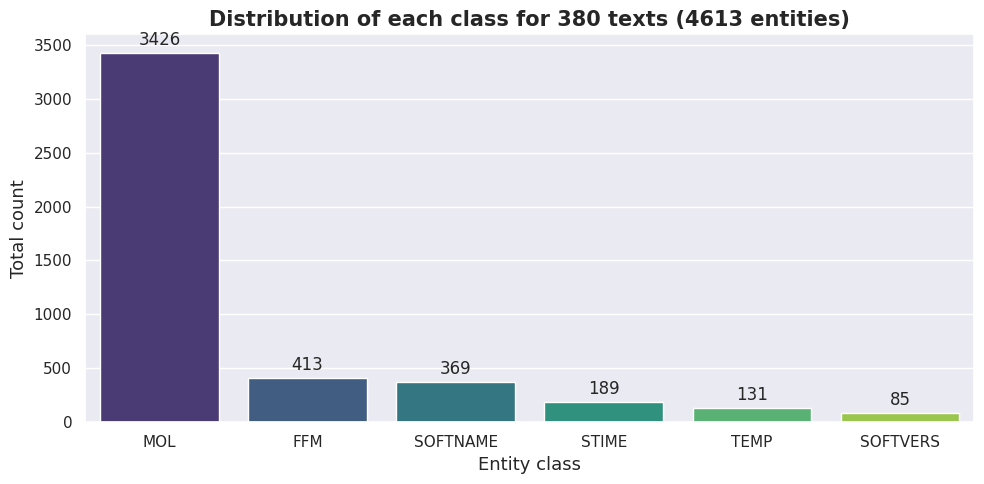

In [36]:
def plot_class_distribution(df: pd.DataFrame) -> None:
    """
    Plot a bar chart showing the total number of entities per class across all files.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing entity counts per file.
    """
    sns.set_theme()
    
    total_entities = len(df)
    cols = [col for col in df.columns if col.startswith("NB_")]
    summary = df[cols].sum().sort_values(ascending=False)
    plot_df = pd.DataFrame({
        "Class": [col.replace("NB_", "") for col in summary.index],
        "Count": summary.values
    })
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=plot_df, x="Class", y="Count", palette="viridis", hue="Class")
    # Add value labels on each bar
    for container in ax.containers:
        ax.bar_label(container, fmt="%.0f", padding=3)
    plt.title(
        f"Distribution of each class for {total_entities} texts ({np.sum(summary.values)} entities)",
        fontsize=15, fontweight="bold"
    )
    plt.xlabel("Entity class", fontsize=13)
    plt.ylabel("Total count", fontsize=13)
    plt.tight_layout()
    plt.show()

plot_class_distribution(df)


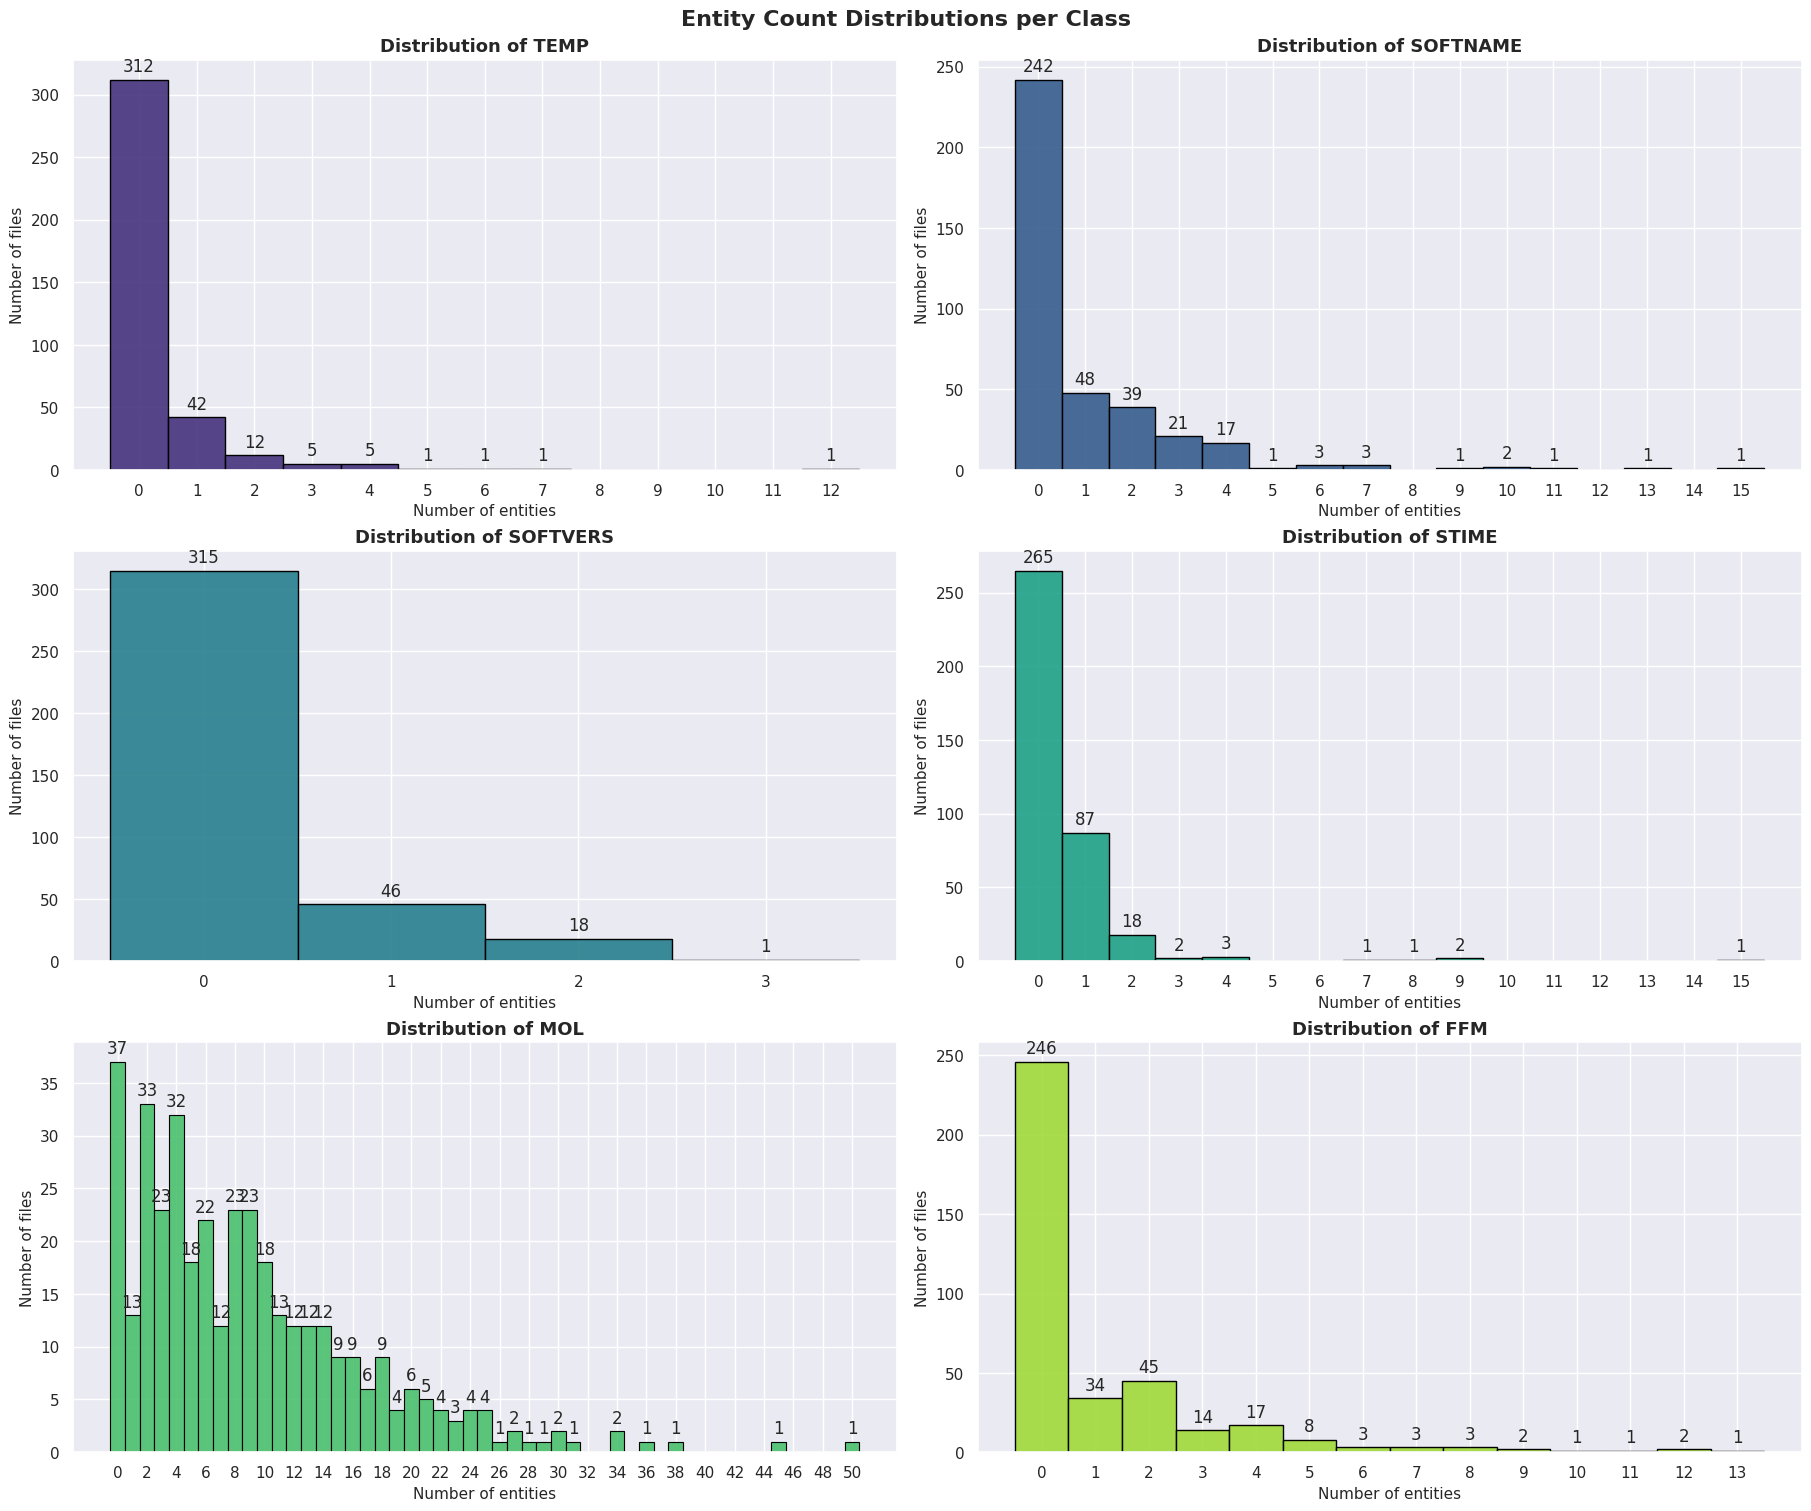

In [37]:
def plot_histograms(df: pd.DataFrame) -> None:
    """
    Plot styled histograms of entity counts for each class in a grid layout (2 per row),
    with value labels and adaptive axis ticks.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing entity counts per file.
    """
    sns.set_theme(style="darkgrid")

    cols = [col for col in df.columns if col.startswith("NB_")]
    n_classes = len(cols)
    palette = sns.color_palette("viridis", n_classes)
    n_cols = 2
    n_rows = math.ceil(n_classes / n_cols)

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(18, 5 * n_rows),
        constrained_layout=True
    )
    axes = axes.flatten()
    for i, col in enumerate(cols):
        ax = axes[i]
        data = df[col]
        max_val = int(data.max())

        sns.histplot(
            data,
            color=palette[i],
            edgecolor="black",
            alpha=0.9,
            discrete=True,
            ax=ax
        )

        # Add value labels on each bar
        for container in ax.containers:
            labels = [f"{int(v.get_height())}" if v.get_height() > 0 else "" for v in container]
            ax.bar_label(container, labels=labels, padding=3)
        # adapt the x range for MOL
        if max_val <= 20:
            step = 1
        else:
            step = 2

        ax.set_xticks(np.arange(0, max_val + 1, step))
        ax.set_title(f"Distribution of {col.replace('NB_', '')}", fontsize=13, fontweight="bold")
        ax.set_xlabel("Number of entities", fontsize=11)
        ax.set_ylabel("Number of files", fontsize=11)


    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Entity Count Distributions per Class", fontsize=16, fontweight="bold")
    plt.show()
    
plot_histograms(df)

In [ ]:
def filter_full_annotations(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filter annotations that contain at least one entity in each class.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing entity counts per file.

    Returns
    -------
    pd.DataFrame
        Filtered DataFrame containing only rows where all NB_* > 0.
    """
    cols = [col for col in df.columns if col.startswith("NB_") and not col == "NB_SOFTVERS"]
    filtered_df = df[(df[cols] > 0).all(axis=1)].reset_index(drop=True)
    print(f"Filtered dataset size: {len(filtered_df)} / {len(df)} annotated texts that contains at least one entity of each relevant class !")
    return filtered_df

filtered_df = filter_full_annotations(df)
filtered_df

Filtered dataset size: 43 / 380 annotated texts that contains at least one entity of each relevant class


,filename,length,NB_TEMP,NB_SOFTNAME,NB_SOFTVERS,NB_STIME,NB_MOL,NB_FFM
0,zenodo_3248612.json,576,3,1,1,1,14,2
1,zenodo_838635.json,1624,1,4,1,1,9,5
2,zenodo_14594.json,646,1,2,2,1,4,2
3,zenodo_6755131.json,1691,1,4,0,1,12,3
4,zenodo_15550.json,526,1,2,2,1,4,2
5,zenodo_13853.json,561,1,2,2,1,4,2
6,zenodo_4300706.json,1174,4,1,1,1,7,2
7,zenodo_1118682.json,667,1,2,2,1,9,4
8,zenodo_6349893.json,931,1,3,0,1,2,3
9,zenodo_14591.json,647,1,2,2,1,4,2


Let's vizualize their entities to check any errors to create a good groundtruth dataset of molecular dynamics annotated texts :

In [45]:
def convert_annotations(file_path):
    """
    Convert annotations from the custom format to spaCy's displaCy format.

    Parameters:
        file_path (str): Path to the JSON file containing "classes" and "annotations" keys.

    Returns:
        List[dict]: A list of dictionaries in the spaCy format.
    """
    with open(file_path, "r") as file:
        data = json.load(file)

    converted = []
    ents = [
        {"start": item["start"], "end": item["end"], "label": item["label"]}
        for item in data["entities"]
    ]
    converted.append({"text": data["raw_text"], "ents": ents})
    return converted


def vizualize_json_entities(list_file_names:list):
    colors = {
        "TEMP": "#ffb3ba",
        "SOFTNAME": "#ffffba",
        "SOFTVERS": "#ffffe4",
        "STIME": "#baffc9",
        "MOL": "#bae1ff",
        "FFM": "#cdb4db",
    }
    options = {"colors": colors}

    for file_name in list_file_names:
        print("=" * 80)
        print(f"🧐 VISUALIZATION OF ENTITIES ({file_name})")
        print("=" * 80)
        path = f"{ANNOT_FOLDER}/{file_name}"
        converted_data = convert_annotations(path)
        displacy.render(converted_data, style="ent", manual=True, options=options)
        print("")


In [107]:
annotation_file_names = filtered_df["filename"]
vizualize_json_entities(annotation_file_names)

🧐 VISUALIZATION OF ENTITIES (zenodo_3248612.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_838635.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_14594.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_6755131.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_15550.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_13853.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_4300706.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_1118682.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_6349893.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_14591.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_1293813.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_7323535.json)



🧐 VISUALIZATION OF ENTITIES (figshare_4806544.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_1293762.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_3975394.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_1009027.json)



🧐 VISUALIZATION OF ENTITIES (figshare_8046437.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_51754.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_5060102.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_34415.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_1198454.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_1009607.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_3950029.json)



🧐 VISUALIZATION OF ENTITIES (figshare_4757161.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_7007107.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_1198171.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_3988469.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_53151.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_51185.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_51747.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_1198158.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_247386.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_30894.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_51760.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_259443.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_2653735.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_1219494.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_30904.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_53212.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_1488094.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_51750.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_14592.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_1167532.json)


In [58]:
def copy_json_data_to_result(
    df: pd.DataFrame,
    source_folder: str,
    dest_folder: str
):
    """
    Copy JSON annotation files corresponding to low-entity filenames.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing annotation results (must include 'filename').
    source_folder : str
        Path to folder containing annotation JSON files.
    dest_folder : str
        Target folder to copy JSON files into.
    """
    os.makedirs(dest_folder, exist_ok=True)
    copied = 0

    for fname in df["filename"]:
        src_path = os.path.join(source_folder, fname)

        if not os.path.isfile(src_path):
            print(f"⚠️  File not found: {src_path}")
            continue
        
        dst_path = os.path.join(dest_folder, fname)
        shutil.copy(src_path, dst_path)
        copied += 1

    print(f"✅ Copied {copied} JSON files to {dest_folder}")

copy_json_data_to_result(filtered_df, ANNOT_FOLDER, DEST_FOLDER)

✅ Copied 43 JSON files to ../results/groundtruth_annotations


Let's correct them :)

In [70]:
def remove_entity_annotation_file(file_name: str, entities_to_remove: list) -> None:
    """
    Remove specific entities from a formatted annotation JSON file.

    Parameters
    ----------
    file_name : str
        Name of the JSON file located in the formatted annotations directory.
    entities_to_remove : list
        A list of tuples of the form (label, text) specifying which entities
        should be removed. Example: [("MOL", "water"), ("TEMP", "37°C")]
    """
    file_path = f"{DEST_FOLDER}/{file_name}"
    
    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)
        original_count = len(data["entities"])
        
        data["entities"] = [
            ent for ent in data["entities"]
            if (ent["label"], ent["text"]) not in entities_to_remove
        ]        
        removed_count = original_count - len(data["entities"])
        #print(f"{removed_count} entities removed from file : {file_name}")

    out_path = f"{DEST_FOLDER}/{file_name}"
    with open(out_path, "w", encoding="utf-8") as file:
       json.dump(data, file, ensure_ascii=False, indent=4)


def find_entity_positions(raw_text: str, entity_text: str) -> list[tuple[int, int]]:
    """Find all occurrences of an entity text inside the raw annotation text.

    This function scans the raw text and returns every (start, end) character
    index pair where the entity text appears. It supports repeated occurrences.

    Parameters
    ----------
    raw_text : str
        The full text in which to search for occurrences.
    entity_text : str
        The substring corresponding to the entity that should be located.

    Returns
    -------
    list[tuple[int, int]]
        A list of (start, end) positions for each occurrence of the entity text.
        Returns an empty list if the text is not found.
    """
    positions = []
    start_idx = 0

    # Search for all occurrences iteratively
    while True:
        start = raw_text.find(entity_text, start_idx)
        if start == -1:
            break  # no more occurrences

        end = start + len(entity_text)
        positions.append((start, end))

        # Move search index forward to avoid infinite loops
        start_idx = end

    return positions


def add_entity_annotation_file(file_name: str, new_entities: list):
    """Add new entities to an existing formatted annotation file.

    This function loads an annotation file, finds all occurrences of new entity
    texts inside the raw text, and appends corresponding entity dictionaries to
    the "entities" list. It supports inserting multiple labels and occurrences
    per label.

    Parameters
    ----------
    file_name : str
        Name of the formatted annotation JSON file.
    new_entities : list
        A list of (label, text) tuples representing the entities to insert.
        Example: [("MOL", "water"), ("TEMP", "37°C")]

    Returns
    -------
    None
        The function updates and rewrites the JSON file.
    """
    file_path = f"{DEST_FOLDER}/{file_name}"
    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    raw_text = data["raw_text"]
    for label, text in new_entities:
        positions = find_entity_positions(raw_text, text)

        for start, end in positions:
            entity_dict = {
                "label": label,
                "text": text,
                "start": start,
                "end": end
            }

            if entity_dict not in data["entities"]:
                data["entities"].append(entity_dict)

    out_path = f"{DEST_FOLDER}/{file_name}"
    with open(out_path, "w", encoding="utf-8") as file:
        json.dump(data, file, ensure_ascii=False, indent=4)


def correct_and_vizualize(file_name:str, add_ent: list = None, remove_ent: list = None):
    if add_ent:
        add_entity_annotation_file(file_name, add_ent)
    if remove_ent:
        remove_entity_annotation_file(file_name, remove_ent)

    colors = {
        "TEMP": "#ffb3ba",
        "SOFTNAME": "#ffffba",
        "SOFTVERS": "#ffffe4",
        "STIME": "#baffc9",
        "MOL": "#bae1ff",
        "FFM": "#cdb4db",
    }
    options = {"colors": colors}
    print("=" * 80)
    print(f"🧐 VISUALIZATION OF ENTITIES ({file_name})")
    print("=" * 80)
    path = f"{DEST_FOLDER}/{file_name}"
    converted_data = convert_annotations(path)
    displacy.render(converted_data, style="ent", manual=True, options=options)
    print("")

In [71]:
# zenodo_3248612.json
correct_and_vizualize("zenodo_3248612.json", [("TEMP", "310K")], [("TEMP", "310K.")])

🧐 VISUALIZATION OF ENTITIES (zenodo_3248612.json)


In [72]:
correct_and_vizualize("zenodo_838635.json", None, [("SOFTNAME", "PLUMED")])

🧐 VISUALIZATION OF ENTITIES (zenodo_838635.json)


In [76]:
correct_and_vizualize("zenodo_6755131.json", [("SOFTNAME", "Amber"), ("SOFTVERS", "2018")], [("SOFTNAME", "PLUMED"), ("SOFTNAME", "PROPKA"), ("SOFTNAME", "Robetta"), ("SOFTNAME", "SHAKE"), ("FFM", "Amber2018"), ("SOFTNAME", "Antechamber")])

🧐 VISUALIZATION OF ENTITIES (zenodo_6755131.json)


In [77]:
correct_and_vizualize("zenodo_4300706.json", [("TEMP", "358K")], [("TEMP", "358K.")])

🧐 VISUALIZATION OF ENTITIES (zenodo_4300706.json)


In [78]:
correct_and_vizualize("zenodo_1118682.json", None, [("FFM", "ECC-ions.")])

🧐 VISUALIZATION OF ENTITIES (zenodo_1118682.json)


In [80]:
correct_and_vizualize("zenodo_7323535.json", [("TEMP", "300 K")], [("TEMP", "300 K.")])

🧐 VISUALIZATION OF ENTITIES (zenodo_7323535.json)


In [81]:
correct_and_vizualize("figshare_4806544.json", [("MOL", "3g5u" ), ("MOL", "4m1m" ), ("MOL", "4ksb" ), ("MOL", "POPC" ), ("MOL", "CLR" ), ("MOL", "3G5U" ), ("MOL", "4KSB" ), ("MOL", "4M1M" )])

🧐 VISUALIZATION OF ENTITIES (figshare_4806544.json)


In [ ]:
correct_and_vizualize("zenodo_1293762.json", None, [("STIME", "100 ns")])

🧐 VISUALIZATION OF ENTITIES (zenodo_1293762.json)


In [83]:
correct_and_vizualize("figshare_8046437.json", None, [("SOFTNAME", "LINCS")])

🧐 VISUALIZATION OF ENTITIES (figshare_8046437.json)


In [84]:
correct_and_vizualize("zenodo_51754.json", [("TEMP", "323 K" )], [("TEMP", "323 K."), ("SOFTNAME", "LINCS" ), ("SOFTNAME", "SETTLE" )])

🧐 VISUALIZATION OF ENTITIES (zenodo_51754.json)


In [85]:
correct_and_vizualize("zenodo_5060102.json", [("TEMP", "310 K" )], [("SOFTNAME", "ANI2x" ), ("TEMP", "310 K.")])

🧐 VISUALIZATION OF ENTITIES (zenodo_5060102.json)


In [86]:
correct_and_vizualize("zenodo_3950029.json", [("TEMP", "358K")], [("TEMP", "358K.")])

🧐 VISUALIZATION OF ENTITIES (zenodo_3950029.json)


In [ ]:
correct_and_vizualize("figshare_4757161.json", [("MOL", "hydrogen"), ("SOFTVERS", "16")], [("SOFTNAME", "SHAKE"), ("SOFTNAME", "Amber16"), ("MOL", "Enzyme")])

🧐 VISUALIZATION OF ENTITIES (figshare_4757161.json)


Here Version 16 of Amber is added but it add also 16 in `"with C 16 alkyl chain attached"`. It's a problem... Maybe we can put a condition : only softvers if there is softname before ?

In [89]:
correct_and_vizualize("zenodo_7007107.json", [("MOL", "phosphoenolpyruvate synthase")], None)

🧐 VISUALIZATION OF ENTITIES (zenodo_7007107.json)


In [90]:
correct_and_vizualize("zenodo_1198171.json", [("MOL", "calcium" )], None)

🧐 VISUALIZATION OF ENTITIES (zenodo_1198171.json)


In [91]:
correct_and_vizualize("zenodo_3988469.json", [("MOL", "ARB" ), ("SOFTNAME", "AMBER"), ("SOFTVERS", "16")], [("SOFTNAME", "SHAKE"), ("SOFTNAME", "AMBER16")] )

🧐 VISUALIZATION OF ENTITIES (zenodo_3988469.json)


In [92]:
correct_and_vizualize("zenodo_53151.json", [("TEMP", "323 K")], [("TEMP", "323 K."), ("SOFTNAME", "LINCS" ), ("SOFTNAME", "SETTLE" )])

🧐 VISUALIZATION OF ENTITIES (zenodo_53151.json)


In [93]:
correct_and_vizualize("zenodo_51747.json", [("TEMP", "323 K" )], [("TEMP", "323 K."), ("SOFTNAME", "LINCS" ), ("SOFTNAME", "SETTLE" )])

🧐 VISUALIZATION OF ENTITIES (zenodo_51747.json)


In [94]:
correct_and_vizualize("zenodo_51760.json", [("TEMP", "323 K")], [("TEMP", "323 K."), ("SOFTNAME", "LINCS" ), ("SOFTNAME", "SETTLE" )])

🧐 VISUALIZATION OF ENTITIES (zenodo_51760.json)


In [95]:
correct_and_vizualize("zenodo_259443.json", [("TEMP", "310 K" ), ("MOL", "CaCl" )], [("TEMP", "310 K."), ("MOL", "CaCl_2" )])

🧐 VISUALIZATION OF ENTITIES (zenodo_259443.json)


In [96]:
correct_and_vizualize("zenodo_2653735.json", [("TEMP", "333 K" )], [("TEMP", "333 K.")])

🧐 VISUALIZATION OF ENTITIES (zenodo_2653735.json)


In [97]:
correct_and_vizualize("zenodo_53212.json", [("TEMP", "323 K" ), ("STIME", "190 ns")], [("TEMP", "323 K."), ("SOFTNAME", "LINCS" ), ("SOFTNAME", "SETTLE" ), ("STIME", "190 ns.")])

🧐 VISUALIZATION OF ENTITIES (zenodo_53212.json)


In [98]:
correct_and_vizualize("zenodo_51750.json", [("TEMP", "323 K" ), ("STIME", "110 ns")], [("TEMP", "323 K."), ("SOFTNAME", "LINCS" ), ("SOFTNAME", "SETTLE" ), ("STIME", "110 ns.")])

🧐 VISUALIZATION OF ENTITIES (zenodo_51750.json)


In [99]:
correct_and_vizualize("zenodo_1167532.json", [("TEMP", "298 K" )], [("TEMP", "298 K.")])

🧐 VISUALIZATION OF ENTITIES (zenodo_1167532.json)


We can now also retrieve a few texts with very few entities (i.e., with limited information for the LLM) to observe their behavior and see whether they tend to invent or hallucinate entities.

In [ ]:
def retrieve_low_entity_texts(
    df: pd.DataFrame,
    n_low: int = 10
) -> pd.DataFrame:
    """
    Retrieve a small sample of low-entity texts.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing entity counts per file.
    n_low : int
        Number of low-entity texts to retrieve for LLM hallucination analysis.

    Returns
    -------
    pd.DataFrame
        Sample DataFrame of low-entity texts.
    """
    cols = [col for col in df.columns if col.startswith("NB_")]
    df["TOTAL_ENTITIES"] = df[cols].sum(axis=1)

    # Select lowest-entity samples
    low_entity_df = (
        df.sort_values("TOTAL_ENTITIES")
          .head(n_low)
          .reset_index(drop=True)
    )

    print(f"Retrieved {len(low_entity_df)} low-entity texts for hallucination analysis.")

    return low_entity_df

low_entity_df = retrieve_low_entity_texts(df, n_low=10)
low_entity_df

Retrieved 10 low-entity texts for hallucination analysis.


,filename,length,NB_TEMP,NB_SOFTNAME,NB_SOFTVERS,NB_STIME,NB_MOL,NB_FFM,TOTAL_ENTITIES
0,figshare_21158960.json,2031,0,0,0,0,0,0,0
1,figshare_21304804.json,1382,0,0,0,0,0,0,0
2,zenodo_3540691.json,648,0,0,0,0,0,0,0
3,figshare_1545562.json,1168,0,0,0,0,0,0,0
4,figshare_11356691.json,1304,0,0,0,0,0,0,0
5,figshare_7069778.json,1886,0,0,0,0,0,0,0
6,figshare_19971077.json,1500,0,0,0,0,0,0,0
7,figshare_19775703.json,1362,0,0,0,0,0,0,0
8,zenodo_6580992.json,655,0,0,0,0,0,0,0
9,figshare_10269416.json,2562,0,0,0,0,0,0,0


In [47]:
annotation_file_names = low_entity_df["filename"]
vizualize_json_entities(annotation_file_names)

🧐 VISUALIZATION OF ENTITIES (figshare_21158960.json)



🧐 VISUALIZATION OF ENTITIES (figshare_21304804.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_3540691.json)



🧐 VISUALIZATION OF ENTITIES (figshare_1545562.json)



🧐 VISUALIZATION OF ENTITIES (figshare_11356691.json)



🧐 VISUALIZATION OF ENTITIES (figshare_7069778.json)



🧐 VISUALIZATION OF ENTITIES (figshare_19971077.json)



🧐 VISUALIZATION OF ENTITIES (figshare_19775703.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_6580992.json)



🧐 VISUALIZATION OF ENTITIES (figshare_10269416.json)


Now we can save them into a dedicated folder : `results/groundtruth_annotations/low_entity` :

In [60]:
path = f"{DEST_FOLDER}/low_entity"
copy_json_data_to_result(low_entity_df, ANNOT_FOLDER, path)

✅ Copied 10 JSON files to ../results/groundtruth_annotations/low_entity
